## Load the images
The images are loaded from the `captured_images` directory.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import ipywidgets as widgets
import PIL
import os
import glob
import cv2
from tqdm import tqdm
import pandas as pd
from sklearn.cluster import KMeans
from skimage import data, filters

plt.rcParams['animation.embed_limit'] = 200 # Set the maximum size of a video to 200 MB
np.set_printoptions(suppress=True) # no scientific notation (e.g. 3.4e-3)

%matplotlib inline
image_directory = '../captured_images'

All folders with images in `captured_images`. Choose the folder you want to use and enter the index in the next cell. The descriptions are imported from `description_per_folder.txt`

In [2]:
image_folders = os.listdir(image_directory)
image_folders = [f for f in image_folders if not f.startswith('description')]
with open('../captured_images/description_per_folder.txt') as f:
    lines = f.readlines()
    
print("List of all the folders inside captured_images with a description from .description_per_folder.txt:\n")
print(" Index | Folder")
print("-------------------------------")
for idx, image_folder in enumerate(image_folders):
    print(f"   {idx}" + " " * (4 - len(str(idx))) + f"| {image_folder}")
    image_folder += '\n'
    if image_folder in lines:
        index = lines.index(image_folder)
        description = lines[index + 1]
        print("       | " +description.replace('\n', '').replace('.', '.\n       |'))


List of all the folders inside captured_images with a description from .description_per_folder.txt:

 Index | Folder
-------------------------------
   0   | 20190121-140205
       | Images from the dataset from Brightspace.
       | Cyberzoo with orange poles and a partly orange panel.
       |
   1   | 20190121-142935
       | Images from the dataset from Brightspace.
       | Cyberzoo with orange poles, a partly orange panel and floor mats.
       |
   2   | 20190121-135009
       | Images from the dataset from Brightspace.
       | Cyberzoo with orange poles.
       |
   3   | 20230301-163805
       | Images captured in the Cyberzoo during the practical session on 1 March.
       | The orange pixels are converted to white pixels.
       |


In [3]:
index_of_the_folder_you_want_to_use = 1

In [4]:
selected_folder = os.path.join(image_directory, image_folders[index_of_the_folder_you_want_to_use])
images = []
for filename in sorted(os.listdir(selected_folder)):
    file_location = os.path.join(selected_folder, filename)
    im = np.asarray(PIL.Image.open(file_location).rotate(90, expand = 1))
    images.append(im)


Some images from the folder...


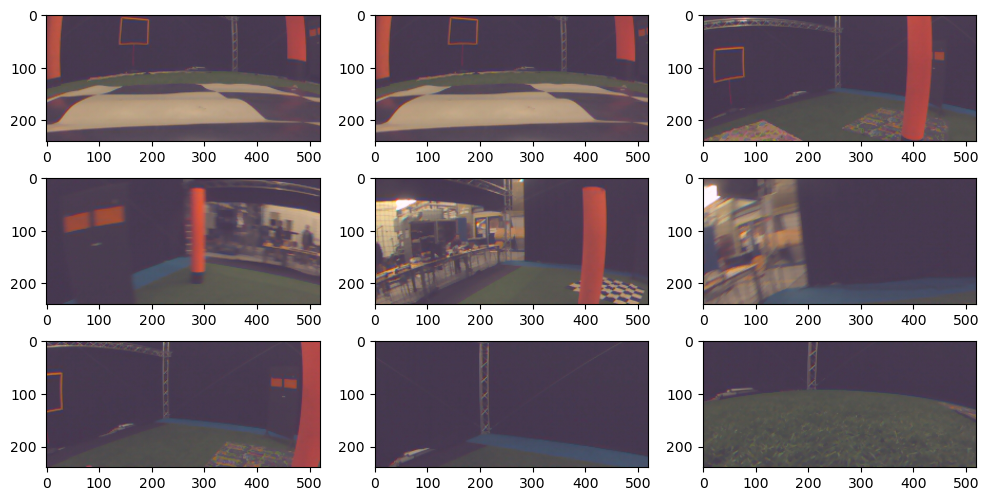

In [5]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(12, 6)
factor = len(images) // 8
indeces = np.array([factor * i for i in range(8)] + [-1]).reshape(3,3)

print("Some images from the folder...")
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.imshow(images[indeces[i, j]])

#### This function can be used to test your algorithm. It applies the algorithm to every images in the list of images you provide.

In [6]:
def test_algorithm(images, algorithm, **kwargs):
    converted_images = []
    for image in images:
        converted_images.append(algorithm(image, **kwargs))
        
    return converted_images

In [7]:
def create_video(images, fps=6):
    """ Really slow for a few hunderd of images """
    fig, ax = plt.subplots()
    anim_ims = []
    for image in images:
        im = ax.imshow(image, animated=True)
        anim_ims.append([im])
    ani = animation.ArtistAnimation(fig, anim_ims, interval=int(1000/fps), blit=True,
                                    repeat_delay=1000)
    plt.close()
    return HTML(ani.to_jshtml())

In [8]:
def create_widget_slider(images):
    """ Almost instantaneously produced"""
    @widgets.interact(index=(0, len(images)-1))
    def f(index=0):
        plt.imshow(images[index])

In [9]:
# Save a mp4 video
step = 1
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('test.mp4', fourcc, 6.0, (520//step,240//step))
for image in images:
    out.write(image[::step,::step,::1])
    
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [10]:
# cap = cv2.VideoCapture('test.mp4')
# fgbg = cv2.createBackgroundSubtractorKNN()
  
# while(1):
#     ret, frame = cap.read()
  
#     fgmask = fgbg.apply(frame-10,None, 0.08)
   
#     cv2.imshow('fgmask', fgmask)
#     cv2.imshow('frame',frame )
  
      
#     k = cv2.waitKey(30) & 0xff
#     if k == 27:
#         break
      
  
# cap.release()
# cv2.destroyAllWindows()

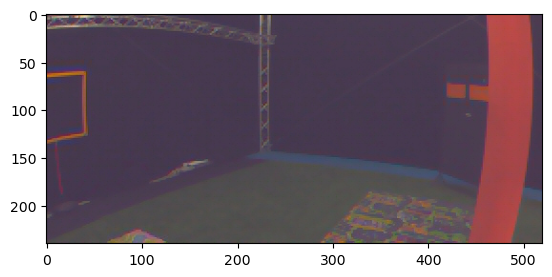

In [11]:
plt.imshow(images[350])

In [12]:
selected_folder = os.path.join(image_directory, image_folders[index_of_the_folder_you_want_to_use])
images = []
filenames = []
for filename in sorted(os.listdir(selected_folder)):
    file_location = os.path.join(selected_folder, filename)
    im = np.asarray(PIL.Image.open(file_location).rotate(90, expand = 1))
    filenames.append(file_location)
    images.append(im)
    

In [13]:
# TESTING SOME ALGORITHMS TO EXTRACT OBJECT CORNERS

In [173]:
# Read in the stored video
video_capture = cv2.VideoCapture('test.mp4')

# Initialize kernel for frame erosion and dilation
kernel = None

# Construct the background substractor, history is set at 100 frames and detect shadows = True to avoid merging contours
background_substractor = cv2.createBackgroundSubtractorKNN(history = 75, detectShadows = True)

# Loop over all frames
ret = True

# Opticflow parameters
first_frame_color   = images[0]
previous_frame_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
mask                = np.zeros_like(first_frame)
mask[..., 1]        = 255

# Store contours and optical flow vectors
object_contours      = []
optical_flow_vectors = []
while(ret):
    
    # Read video frame
    ret, frame = video_capture.read()
    
    if not ret:
        break

    # Obtain the foreground mask by applying background subtractor to current frame
    masked_foreground = background_substractor.apply(frame)
    
    # Threshold the masked_foreground based on pixel intensity current value = 100
    _, masked_foreground = cv2.threshold(masked_foreground, 150, 255, cv2.THRESH_BINARY)
    
    # Apply frame erosion and dilation to filter out background noise
    #masked_foreground = cv2.erode(masked_foreground, kernel, iterations = 1)
    #masked_foreground = cv2.dilate(masked_foreground, kernel, iterations = 1)
    
    # Find contours in the masked foreground image
    contours, _ = cv2.findContours(masked_foreground, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Copy the current original frame to draw the contours
    

    # Loop over each contour found in the frame (Without erosion/dilution)
    #for contour in contours:
    #    if 12500 < cv2.contourArea(contour)< 20000:
            #cv2.drawContours(frameCopy, contour, -1, (0, 255, 255), 2)

    
    # Loop over each contour found in the frame (With rosion/dilution)
    frameCopy = frame.copy()
    for contour in contours:
        if 4000 < cv2.contourArea(contour)< 20000:
            #x,y, width, height = cv2.boundingRect(contour)
            object_contours.append(contour)
            cv2.drawContours(frameCopy, contour, -1, (0, 255, 255), thickness=-1)
                
    # Display original frame, foreground mask and found contours
    horizontal_concat = np.concatenate((frame, frameCopy), axis=1)
    cv2.imshow('HORIZONTAL', horizontal_concat)
    cv2.imshow('frame', masked_foreground)

    # Calculates dense optical flow by Farneback method
    frameCopy2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(previous_frame_gray, frameCopy2, None, 0.5, 3, 10, 2, 5, 0.6, 0)

    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    #   # Sets image hue according to the optical flow direction
    mask[..., 0] = angle * 180 / np.pi / 2

    # Sets image value according to the optical flow magnitude (normalized)
    mask[..., 2] = cv2.normalize(magnitude, None, 1, 255, cv2.NORM_MINMAX)
    
    # Converts HSV to RGB (BGR) color representation
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

    # Opens a new window and displays the output frame
    cv2.imshow("dense optical flow", rgb)
    
    previous_frame_gray = frameCopy2
  
    optical_flow_vis = frame.copy()
    for object_contour in object_contours:
        optical_flow_vectors.append(flow[object_contour[0,0][1], object_contour[0,0][0]])


    # Frames are read by intervals of 1 millisecond. The
    # programs breaks out of the while loop when the
    # user presses the 'q' key
    if cv2.waitKey(20) & 0xFF == ord('q'):
        # Release video object
        video_capture.release()

        # Destroy all windows
        cv2.destroyAllWindows()
        break

In [ ]:
# CORNER DETECTION PIPELINE
#       # detect corners with the goodFeaturesToTrack function.
#     frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_BGR2GRAY)
#     corners = cv2.goodFeaturesToTrack(frameCopy, 4, 0.01, 1)
#     corners = np.int0(corners)

#     # we iterate through each corner, 
#     # making a circle at each point that we think is a corner.
#     frameCopy2 = frame.copy()
#     for i in corners:
#         x, y = i.ravel()
#         cv2.circle(frameCopy2, (x, y), 3, 255, -1)
#     cv2.imshow('frame2', frameCopy2)

In [15]:
# import numpy as np
# import cv2
# from skimage import data, filters
 
# # Open Video
# cap = cv2.VideoCapture('test.mp4')
 
# # Randomly select 25 frames
# frameIds = cap.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=1)
 
# # Store selected frames in an array
# frames = []
# for fid in frameIds:
#     cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
#     ret, frame = cap.read()
#     frames.append(frame)
 
# # Calculate the median along the time axis
# medianFrame = np.median(frames, axis=0).astype(dtype=np.uint8)    
 
# # Display median frame
# # cv2.imshow('frame', medianFrame)
# # cv2.waitKey(0)

In [16]:
# # Reset frame number to 0
# cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
# ret, first_frame = cap.read()

# # Convert background to grayscale
# grayMedianFrame = cv2.cvtColor(medianFrame, cv2.COLOR_BGR2GRAY)
# previous_frame = grayMedianFrame

# # Loop over all frames
# ret = True

    
# # Converts frame to grayscale because we
# # only need the luminance channel for
# # detecting edges - less computationally 
# # expensive
# prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
  
# # Creates an image filled with zero
# # intensities with the same dimensions 
# # as the frame
# mask = np.zeros_like(first_frame)
  
# # Sets image saturation to maximum
# mask[..., 1] = 255

# while(ret):
 
#   # Read frame
#   ret, frame = cap.read()
#   # Convert current frame to grayscale
#   frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#   # Calculate absolute difference of current frame and 
#   # the median frame
#   dframe = cv2.absdiff(frame, previous_frame)
#   # Treshold to binarize
#   th, dframe = cv2.threshold(dframe, 5, 255, cv2.THRESH_BINARY)
  
#   previous_frame = frame
  
#   # Display image
#   cv2.imshow('frame', dframe)
#   cv2.waitKey(20)


#   # Frames are read by intervals of 1 millisecond. The
#   # programs breaks out of the while loop when the
#   # user presses the 'q' key
#   if cv2.waitKey(1) & 0xFF == ord('q'):
#       break


# # Release video object
# cap.release()
 
# # Destroy all windows
# cv2.destroyAllWindows()